<h1>California Housing Data Project</h1>

<h2> A "Hands-On Machine Learning with Scikit-Learn and TensorFlow" Project </h2>

<p>In this project/task I am practicing some basic concepts from the second chapter of "Hands-On Machine Learning with Scikit-Learn and TensorFlow" that go over working with Pandas, Matplotlib, NumPy and Scikit-Learn (Géron, 2017).</p>

<p>The dataset that is being used for this project is one from the StarLib repository, containing information about California Housing Prices based on data from the 1990 California consensus (Pace & Barry, 1997).</p>

***

<h2> References </h2>

<ul>
    <li>Pace, R.K., Barry, R. (1997). “Sparse Spatial Autoregressions,” Statistics & Probability Letters 33, no. 3 (1997): 291–297.</li>
    <li>
        Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow.</li>
   
</ul>



In [1]:
import os
import pandas as pd
import numpy as np

# 1. Getting the dataset

> First we need to get the data which is stored on GitHub. For which we will write a function that downloads the dataset file (.tgz)and extracts it in a CSV format in the `./dataset/housing` folder.

In [2]:
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = 'datasets/housing'
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + '/housing.tgz'

def fetch_housing_data(housing_url= HOUSING_URL, housing_path= HOUSING_PATH):
    """
    Requires a the data origin path (housing_url) and the data destination path (housing_path).
    
    1. Checks if the housing_path exists under our root dir. If not, creates it.
    2. Downloads the dataset (which is in .tgz format) to the root/housing_path.
    3. Extracts all files from the dataset to the root/housing_path folder.
    
    """
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()


fetch_housing_data()

## <li> Loading the dataset in a pd.DataFrame() and initial overview of the data </li>

> We will write a function that loads the data into a `pd.DataFrame()`.

In [3]:
def load_housing_data(housing_path= HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

housing = load_housing_data()

> An initial view of our data.

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


> The `info()` method is useful to get a quick description of the data. It shows the total number of rows containing non-null values and each attribute's type.

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


> `ocean_proximity` is the only attribute of type `<object>` and since it has been loaded from a CSV file it is safe to assume it is a text attribute.


In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

## Another quick overview of the data is to plot a histogram for each numerical attribute

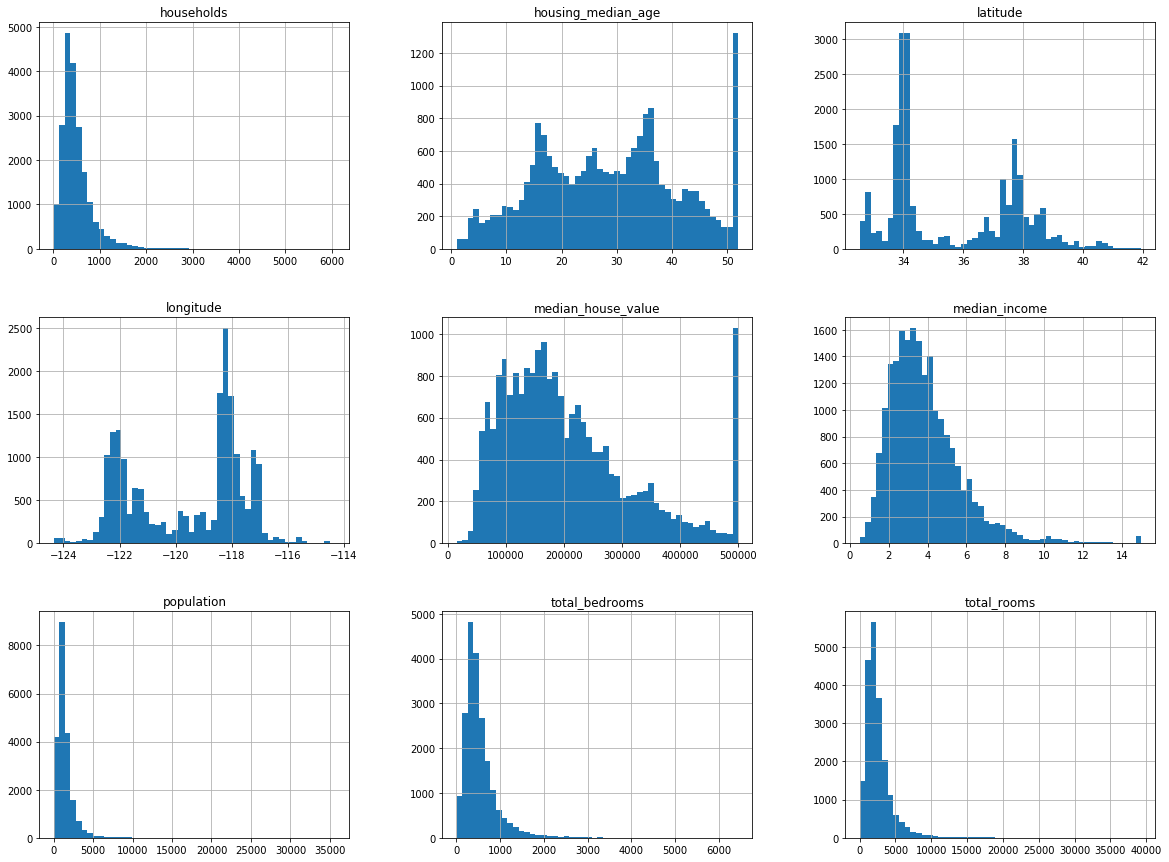

In [7]:
%matplotlib inline 

# important to have the plots generated here in Jupyter

import matplotlib.pyplot as plt

housing.hist(bins= 50, figsize= (20, 15)) # Figsize accepts a (height, length) tuple
plt.show() 

# If you don't write this line, you will get all of the additional info about the plot objects (memory space and etc.)

We can observe several things in these histograms:
<ol>
    <li> The median income attribute does not look like it is expressed in US dollars (USD). It is actually scaled and capped at 15 for higher median incomes and 0.5 for lower median incomes.
    </li> <br>
    <li> The housing median age and median house value are also capped. Since median house value is the target attribute it may be a serious problem for the ML algorithm - they may learn that prices do not go over the cap ($500,000). <br><br> This can be fixed by either: <br>
    <ul>
        <li> 
        Collecting the real values for the districts with capped attribues.
        </li>
        <li> 
        Removing these districts from the dataset.
        </li>
        </ul>
    </li><br>
    <li>
    The attributes have very different scales. We need to explore feature  scaling.
    </li><br>
    <li>
    The histograms are <i>tail heavy</i>: they are skewed to the right and we will try transforming those attribues to a more bell-shaped distributions.
    </li>
</ol>

# 2. Creating a Test Set 

> We need to set aside 20% of the data for testing purposes. For that purpose we will use `train_test_split` from `sklearn.model_selection`

In [8]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, 
                                       test_size= 0.2,
                                       random_state= 42)
print('Train set:', len(train_set), "+ Test set:", len(test_set))

Train set: 16512 + Test set: 4128


> People often set the random seed/ random_state to 42, for no other reason than - 42 is the Answer of the Ultimate Question of Life, the Universe, and Everything.

## A need for Stratified Sampling
 What we had done above is a random sampling methodology, which is generally fine if the dataset is large enough, however, if that isn't the case, there is a risk of introducing a sampling bias. Since, it could be hypothesized that the `median income` is a very important attribute to predict our target `median housing prices`, we can perform a **stratified sampling** based on `median income` and split our test and training sets accordingly. 
 
Since the `median income` is a continuous numerical attribute, we need to create an income category attribute.

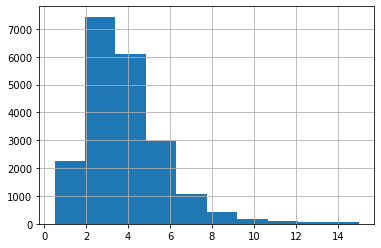

In [9]:
housing['median_income'].hist()
plt.show()

> It seems that most of the values are clustured around the range 2-5, however there are still values well beyond 6. To ensure that there are enough instances in each of our categories, we will merge all categories beyond 5 into category 5. We will create an income category attribute by dividing the median income by 1.5 and rounding up using `np.ceil` (to have discreet categories).

In [10]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)

> `np.ceil()` is used to round up a float to its "ceil".

> `np.floor()` does the opposite.


In [11]:
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace= True)

> To split the dataset into **train_set** and **test_set** we will use `StratifiedShuffleSplit` from `sklearn.model_selection`.

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1,
                              test_size = 0.2,
                              random_state = 42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

> Now to remove the `income_cat` attribute so the data is back to normal.

In [13]:
for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis= 1,inplace= True)
    
for column in strat_train_set.columns:
    print(column)

longitude
latitude
housing_median_age
total_rooms
total_bedrooms
population
households
median_income
median_house_value
ocean_proximity


> **\*Note** - Many methods in Pandas have the parameter `inplace=`. This will complete the operation without you having to reassign the dataframe. 

# 3. Exploratory Data Analysis Through Visualizations

> It is good to first create a copy of the `strat_train_set` by using the `.copy()` method on it, so that we can have the original on the side just in case. 

In [14]:
housing = strat_train_set.copy()

## Geographical Data with Matplolib

Since we have the attributes `latitude` and `longitude` we can plot them on a scatterplot to visualize the data.

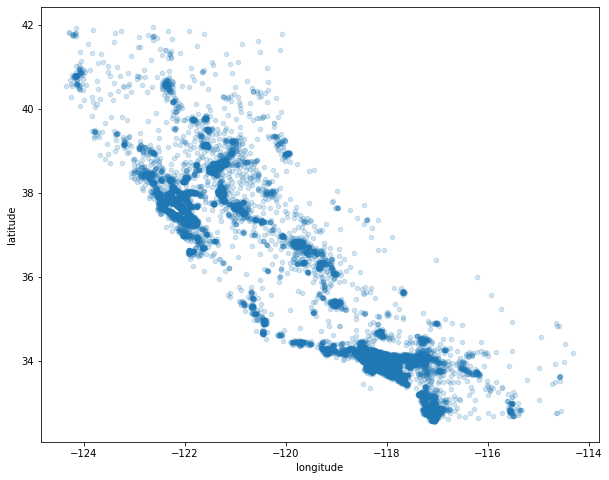

In [15]:
housing.plot(kind = 'scatter',
             x = 'longitude',
             y = 'latitude',
             alpha = 0.2,
             figsize = (10, 8))
plt.show()

> The `figsize=` parameter accepts tuples with height x length values for the figure size.

> `alpha=` controls the opacity of each dot on the scatterplot. In this case, lowering it makes it easier to see places with higher density. 

## Housing Prices and District Population Size

> `s=` represents the radius of each circle/dot, which we have selected to be the `population`. We are dividing it by 100, otherwise the dots will be too big.

> `c=` represents color, or in our case the `median_house_value`

> `cmap= plt.get_cmap('jet')` is a predefined color map called `jet`, which ranges from blue (low values) to red (high values)

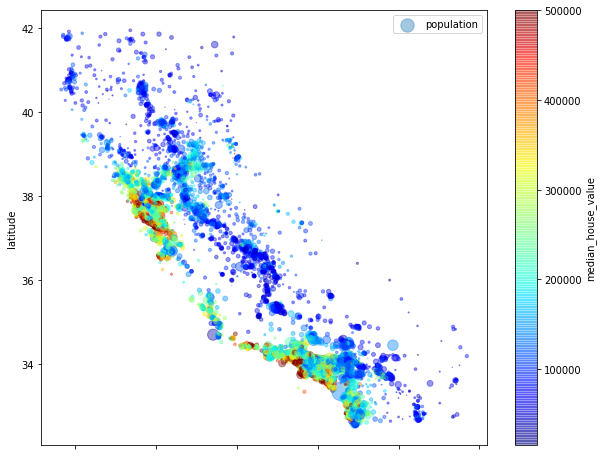

In [16]:
housing.plot(
            kind = 'scatter',
            x = 'longitude',
            y = 'latitude',
            alpha = 0.4,
            s = housing['population'] / 100,
            label = 'population',
            c = "median_house_value",
            cmap = plt.get_cmap('jet'),
            colorbar = True,
            figsize = (10, 8)
            )

plt.show()

# Simple Correlations

> The dataset is not large and we can calculate the correlation coefficients (Pearson's rho) for every pair of attributes using the corr() method.

In [18]:
corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending= False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

<h1 align = "center" style = "color: rgb(80, 150, 93); font-family:sans-serif">
    WARNING </h1>
    
> The correlation coefficient only measures linear correlations( x goes up => y goes up/down). 

> Pandas has a `scatter_matrix` function, which plots every numerical attribute against one another. In this dataset there are 11 numerical attributes which will result in too many plots, so instead we will only choose several promising columns to plot (`median_house_value`, `median_income`, `total_rooms` and `housing_median_age`).

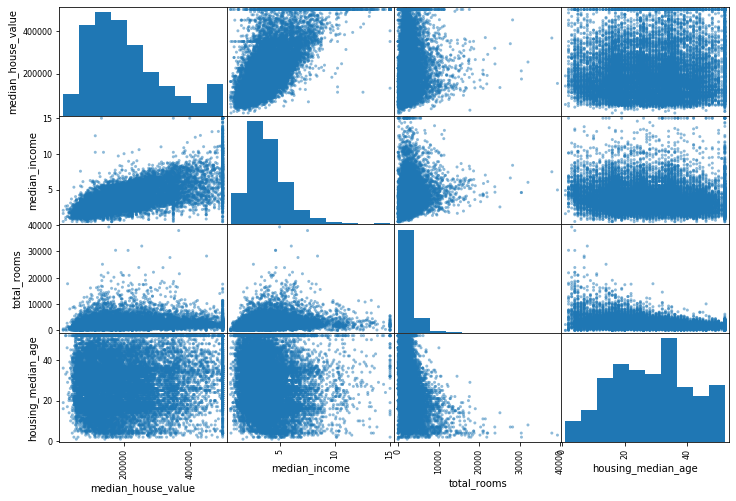

In [20]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize= (12, 8))
plt.show()

> Because every attribute plotted with itself will result in a perfect correlation scatterplot, Pandas instead displays a histogram.

> The most promising attribute predicting our target, `median_house_value`, is `median_income` as seen on the plot above and below

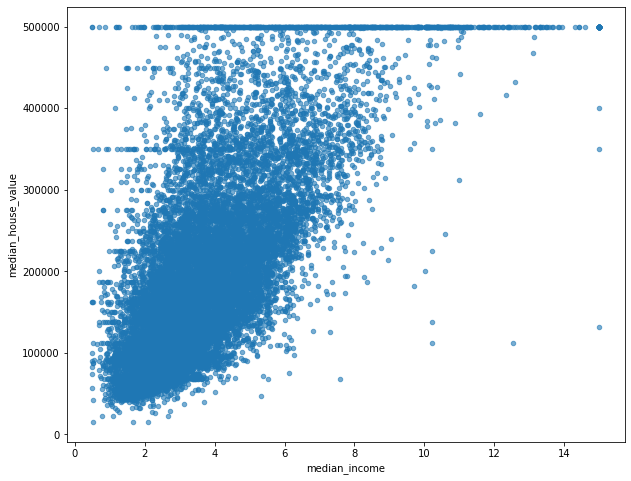

In [25]:
housing.plot(kind= 'scatter',
            x= 'median_income', y= 'median_house_value',
            alpha= 0.6,
            figsize = (10, 8))
plt.show()

> The plot shows a very strong correlation between the attributes and we can also observe the cap at \\$500,000. However, there are also noticeable horizontal lines at \\$450,000, \\$350,000 and \\$280,000. It will be good to remove the corresponding districts as they can teach the algorithm(s) weird quirks about our data.

# Attribute Combinations

> Before preparing the data for the Machine Learning algorithms, we should try combinining different attributes to get more useful ones such as getting the `rooms_per_household` by dividing `total_rooms` in the district by `households`.

In [26]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [27]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending= False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

> We can now see that `bedrooms_per_room` is negatively correlated with our target and `rooms_per_household` - positively. **"Apparetly houses with lower bedroom/room ration tend to be more expensive."** `rooms_per_household` also makes sense as obviously larger houses will tend to be more expensive.

# 4. Preparing the Data for ML Algorithms

> Writing reuseable functions that will be part of a data pipeline (and potentially future data pipelines)


In [28]:
housing = strat_train_set.drop('median_house_value', axis= 1)
housing_labels = strat_train_set['median_house_value'].copy()

# <u>Data Cleaning</u>

# Numerical Attributes: Filling missing values

Firstly getting rid of missing features (many ML algorithms can't work with missing values). For this we can either:
<ul>
    <li>
        Removing the districs with the missing values.
    </li>
    <li>
        Removing the attribute with missing values.
    </li>
    <li>
        Set some value for the missing values (such as "-9999") or the <u>median</u> of the attribute.
    </li>
</ul>

DataFrame has methods such as `dropna()`, `drop()`, and `fillna()` for these purposes.

 For option 3 (<u>median of the attribute</u>) we will need to compute to fill the missing values, but also assign it to variable for later use with the test set. 

Scikit-Learn provides a class that takes care of missing values: `SimpleImputer`. To use it:

 1. Create an instance of `Imputer`, and in the `strategy=` parameter, specify that the median will me used to replace each attribute missing value with the `median` of the attribute.


In [31]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy= 'median')

2. Create a version of the DataFrame with only numerical attributes (`housing_num`), by `dropping` the `ocean_proximity` attribute.

In [32]:
housing_num = housing.drop('ocean_proximity', axis= 1)

3. Using the `imputer` instance to fit to the training data using the `imputer.fit(DataFrame)` method. This will "train" the `imputer` with the median values of each attribute.

In [33]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [34]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

4.  Now we can use the `imputer` to `transform()` the training set by filling the missing values with the medians of each attribute. This will result in a NumPy array containing the transformed features.

In [36]:
x = imputer.transform(housing_num) # NumPy Array

housing_tr = pd.DataFrame(x, 
                columns=housing_num.columns) # putting it all back in a DataFrame

 # Text and Categorical Attributes

`ocean_proximity` is a categorical (text) attribute. We will convert the text to numbers. Scikit-Learn provides a tranformer for this task called `LabelEncoder`:

In [39]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [40]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


The problem with this type of encoding is that the encoder does not make a difference between `<1h OCEAN` = 0 and `INLAND` = 1, which will wrongly order our categories. To solve this we can simple divide the categories of the attribute into 5 separate attributes with binary values (0, 1) depending on if the category is active or not for the disctrict(row). 

This technique of encoding is called *one-hot-encoding* - (1 = 'hot', 0 = 'cold').

> Scikit-Learn provides a `OneHotEncoder` to convert integer categorical values into one-hot vectors. \\* Note - `fit_transform()` expects a 2D array, but `housing_cat_encoded` is a 1D array. We need to reshape it first.

In [41]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

c:\users\ipagera\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

> `one-hot encoding` returns a sparse matrix, as with the categorical attributes you get an enormous matrix full of zeroes except for 1 per row, which would be the hot value. This will use tons of memory, so to not be wasteful a `sparse matrix` is returned only containing the location of the nonzero elements (where the 1s are). 


Both transformations above `LabelEncoder` and `OneHotEncoder` can be applied with a single `LabelBinarizer` class:

In [42]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

> ^ This returns a NumPy array by default, but it can return a `sparse matrix` by passing the parameter `sparse_output= True` to the `LabelBinarizer(sparse_output= True)` constructor

In [44]:
encoder = LabelBinarizer(sparse_output= True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.int32'>'
	with 16512 stored elements in Compressed Sparse Row format>

# Custom Transformers

Scikit-Learn provides the opportunity to write your own custom transformers as part of your own data pipeline. You simply have to implement your transformer as a class with methods such as `fit()`, `transform()`, `fit_transform()`, `get_params()` and `set_params()`. Scikit-Learn provides two base classes `TransformerMixin` and `BaseEstimator`. 

Inheriting from `TransformerMixin` provides the `fit()`, `transform()` and `fit_transform()` methods and inheriting from `BaseEstimator` provides the `get_params()` and `set_params()` methods. 

All we need to do, besides inheriting from these classes, is defining the `transform()` method and we get a fully functional custom tranformer that can be integrated in the Scikit-Learn data pipeline.


> **Note** - Don't add `*args` and `**kwargs` to the constructor in order to get the `get` and `set_params()` methods.

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, add_bedrooms_per_room= True): # no *args or *kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

> In the example the transformer has one hyperparameter `add_bedrooms_per_room` set to `True` by default. You can tweek that ouside of the class definition to get to new results from the transformer.

> Generally you can add hyperparameters to gate any data preparation step you are not 100% certain about. 

# Feature Scaling

**Feature Scaling** is one of the most important transformations you need to apply to your data. Machine Learning algorithms do not perform well when the input numerical attributes have very different scales. For example - <u> the total number of rooms ranges from 6 to 39,320, while the median incomes range only from 0 to 15</u>

There are two common methods for getting all attributes to the same scale: `min-max scaling` and `standardization`.

`Min-max scaling` (*normalization*) is quite simple: values are shifted and rescaled to that they end up ranging from 0 to 1. This is done by subtracting the min value and dividing the max minus the min. 

Scikit-Learn provides the transformer `MinMaxScaler` for this. It has the `feature_range` hyperparameter that lets you change the range if you don't want the common 0-1 range.

`Standardization` - first it subtracts the mean value and then divides that by the variance so that the resulting distribution has unit variance. <u>Standardization is much less affected by outliers in comparison to Min-max scaling</u>. 

Scikit-Learn provides `StandardScaler` for standardization.

# <u> Transformation Pipelines </u>

Scikit-Learn provides the `Pipeline` class to help with sequences of transformation, to ensure that all steps/transformations in the data pipeline are executed in the right order. The example below shows a pipeline for the numerical attributes of the training set:

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy= 'median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

`Pipeline` constructor takes a list of name/estimator tuples which define the sequence of steps. <u>All but the last estimator must be tranformers</u> (have the `fit_transform()` method). 